მომხმარებლის შედეგიანობის წინასწარმეტყველება
-

In [66]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from itertools import product
from tqdm import tqdm_notebook

ამ ამოცანაში ვეცდებით გამოვიცნოთ თუ რამდენად "შედეგიანი" იქნება კონკრეტული ადამიანისთვის შემდეგი დღეები. მოდი განვმარტოთ რას ნიშნავს "შედეგიანი". მიღებული ნუტრიოტებისა და აპლიკაციის დასახული ნუტრიოტების რაოდენობის საშუალებით პროგრამა ყოველდღე თვლის ქულას, რომელიც დავიმსახურეთ ამ დღეს. ანუ მაგალითად მე თუ დღეს ყველა ნუტრიოტთან მქონდა შედარებით დიდი აცდენა, ვიდრე გუშინ, დღეს აპლიკაცია ნაკლებ ქულას დამიწერს. ამით მომხმარებელს ექნება მეტი მოტივაცია სწორად მიყვეს დასახულ მიზანს და ასევე დაეხმარება მას იმაში, გახდეს სტაბილური და არ გამოტოვოს დღეები (დღის გამოტოვების შემთხვევაში ცხადია მას ქულა დააკლდება). 

In [67]:
# import dataset as pandas.DataFrame
data = pd.read_csv('a.tsv', sep='\t', header=0, names=['Person', 'Date', 'Input', 'Result'])

In [68]:
# აბრუნებს data[row[col]-ის მნიშვნელობას. jsn=True იმ შემთხვევაში თუ სვეტის ელემენტი json ფორმატში არის შენახული
# და ჭირდება დესერილიზაცია

def get_value(data, row, col, jsn):
    if jsn:
        return json.loads(data.iloc[row, col])
    else:
        return data.iloc[row, col]
    
def get_size(data, person):
    return data.loc[data.Person == person, ['Person']].shape[0]

ცხადია, ყველა იუზერისთვის არ შეგვეძლება დასახული ამოცანის ამოხსნა მათზე ინფორმაციის უქონლობის გამო. ამიტომ, გადავწყვიტეთ ავირჩიოთ ისეთი ადამიანები, ვისაც მინიმუმ 50 ჯერ მაინც აქვთ შეყვანილი აპლიკაციაში მონაცემები.

In [69]:
persons = data['Person'].unique()
dt = data.copy()
mp = {}
for person in persons:
    mp[person] = get_size(data, person)
rs = []
for i in data.index:
    rs.append(mp[get_value(data, i, 0, False)])
dt['cnt'] = rs
dt = dt.loc[dt.cnt >= 50, :]
data = dt
data.head()

,Person,Date,Input,Result,cnt
0,1,2014-09-15,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2430}...",173
1,1,2014-09-16,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 1862}...",173
2,1,2014-09-17,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2251}...",173
3,1,2014-09-18,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2001}...",173
4,1,2014-09-19,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2158}...",173


In [70]:
def calories_goal_distribution(data, row):
    result = get_value(data, row, 3, True)
    for i in range(len(result['total'])):
        if result['goal'][i]['name'] == 'Calories':
            return result['goal'][i]['value']
    return -1

In [71]:
def calories_total_distribution(data, row):
    result = get_value(data, row, 3, True)
    for i in range(len(result['total'])):
        if result['total'][i]['name'] == 'Calories':
            return result['total'][i]['value']
    return -1

In [72]:
def get_difference(data, row):
    result = get_value(data, row, 3, True)
    total_calories = 0
    goal_calories = 0
    total_sugar = 0
    goal_sugar = 0
    for i in range(len(result['total'])):
        if result['total'][i]['name'] == 'Sugar':
            total_sugar = result['total'][i]['value']
        if result['total'][i]['name'] == 'Calories':
            total_calories = result['total'][i]['value']
        if result['goal'][i]['name'] == 'Calories':
            goal_calories = result['goal'][i]['value']
        if result['goal'][i]['name'] == 'Sugar':
            goal_sugar = result['goal'][i]['value']
    return abs(goal_calories - total_calories), abs(goal_sugar - total_sugar)

In [73]:
def get_date_index(dates, date):
    for i in range(len(dates)):
        if dates[i] == date:
            return i
    return -1

In [74]:
def dates_contains_date(dates, date):
    for cur_date in dates:
        if cur_date == date:
            return True
    return False

In [75]:
remaining_persons = data['Person'].to_numpy()
person_id = remaining_persons[5];
person_dt = data.loc[data.Person == person_id, :].copy()
person_dates = person_dt['Date'].to_numpy()
dates = data['Date'].unique()

In [76]:
new_dates = []
for date in dates:
    x = datetime.datetime(int(date[0:4]), int(date[5:7]), int(date[8:10]))
    new_dates.append(x)
dates = new_dates
dates.sort()
new_person_dates = []
for date in person_dates:
    x = datetime.datetime(int(date[0:4]), int(date[5:7]), int(date[8:10]))
    new_person_dates.append(x)
person_dates = new_person_dates
person_dates.sort()

ამ ამოცანაში ჩვენთვის ერთ-ერთი ყველაზე რთული ნაწილი არის განვსაზღვროთ ის ქულა, რომელიც მომხმარებელს ეკუთნის. ასეთი რაღაცის დასადგენად საჭიროა ნუტრიოტებში კარგად გარკვეული ჯგუფის მუშაობა და დადგენა შესაბამისი ფორმულისა და კოეფიციენტების. ჩვენ არ გვინდოდა ეს ფორმულა ჰაერიდან მოგვეტანა და ისე ჩაგვეტარებინა კვლევა, ამიტომ გავაკეთეთ რაღაც research-ები, ვკითხეთ აზრი ამ საკითხში გამოცდილ ადამიანებს და რჩევად მივიღეთ, რომ ყველაზე მარტივი, რაც შეგვიძლია გავაკეთოთ არის ის, რომ დავაკვირდეთ და დიდი ყურადღება მივაქციოთ კალორიებსა და შაქარს, კონკრეტული კოეფიციენტებით. 
მთლიანად ვეყრდნობით აპლიკაციის დასახულ გოლ-ს და ნებისმიერ უზუსტობაზე შესაბამის ზომას ვიღებთ. შაქარს ვანიჭებთ 0.3 კოეფიციენტს, ხოლო კალორიებს 0.7-ს. მათ შესაბამის აცდენებს კი ვასკალირებთ, ვამრავლებთ მოცემულ კოეფიციენტებზე, ვჯამავთ და ვაქცევთ [0,100] შუალედში. ეს იქნება ჩვენი საბოლოო ქულა მოცემული დღისათვის.
მაგრამ, ასევე არ გვინდოდა ერთი ჩავარდნის გამო მაგალითად ძალიან ქვევით ჩემოსულიყო ქულები და ძალიან დიდი გავლენა ექონია მომავლისათვის. ამიტომ ქულის დადგენაც გავხადეთ რეკურენტული beta კოეფიციენტი -> beta * currDay + (1 - beta) * prevDay. ამით იჭრება გამოტოვებული დღეების პრობლემაც. 

In [77]:
beta = 0.2
lst = []
lst2 = []
for i in person_dt.index:
    lst.append(get_difference(data, i)[0])
    lst2.append(get_difference(data, i)[1])
mx = max(lst)
mx2 = max(lst2)
if mx == 0:
    mx = 1
if mx2 == 0:
    mx2 = 1
for i in range(len(lst)):
    lst[i] /= mx 
    lst[i] = lst[i] * 0.7 * 100
    lst2[i] /= mx2 
    lst2[i] = lst2[i] * 0.3 * 100
    
results = []
lsts_index = 0
frm = get_date_index(dates, person_dates[0])
to = get_date_index(dates, person_dates[len(person_dates) - 1])
missed_days = 0
for i in range(frm, to+1):
    date = dates[i]
    if not dates_contains_date(person_dates, date):
        missed_days += 1
        results.append(results[len(results) - 1] * beta)
    else:
        if len(results) == 0:
            results.append((1 - beta) * (100 - lst[lsts_index] - lst2[lsts_index]))
        else:
            results.append(results[len(results) - 1] * (1 - beta) + beta * (100 - lst[lsts_index] - lst2[lsts_index]))
        lsts_index += 1

In [1]:
%matplotlib inline

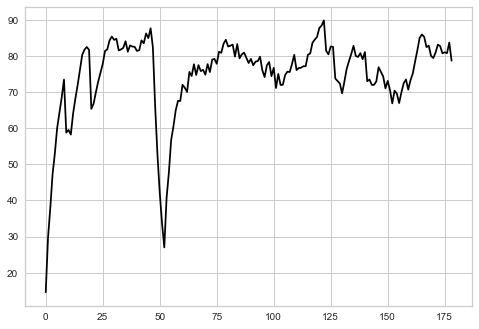

In [78]:
plt.plot(results, color='black')
plt.show()

ARIMA
-

ამ შემთხვევაში გამოვიყენებთ ARIMA მოდელს, რადგან სეზონურობის ნიშანწყალი არ ჩანს და არც სხვა იუზერებისთვის იქნება სეზონური გრაფიკი, უფრო სწორად ძალიან ცოტაა შანსი, რომ რომელიმე იუზერს სეზონური გრაფიკი აღმოაჩნდეს, რადგან ეს მონაცემები რეალური აპლიკაციიდანაა აღებული და ნაკლებ სავარაუდოა, რომ რომელიმე ადამიანის ცხოვრების სტილი იმდენად განმეორებადი იყოს, რომ 50 დღის განმავლობაში სეზონური ყოფაქცევა დაფიქსირდეს.

In [79]:
person_dt = pd.DataFrame({"Function" : results})

In [2]:
%matplotlib inline

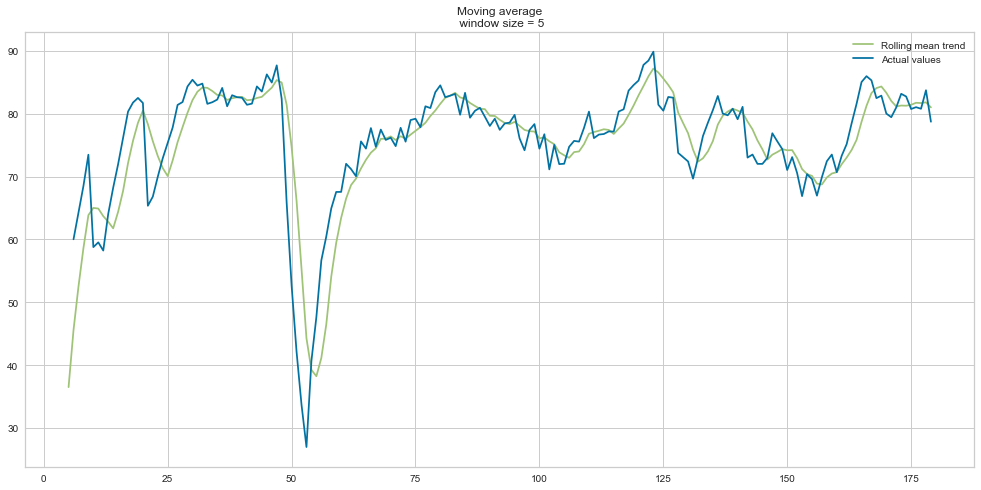

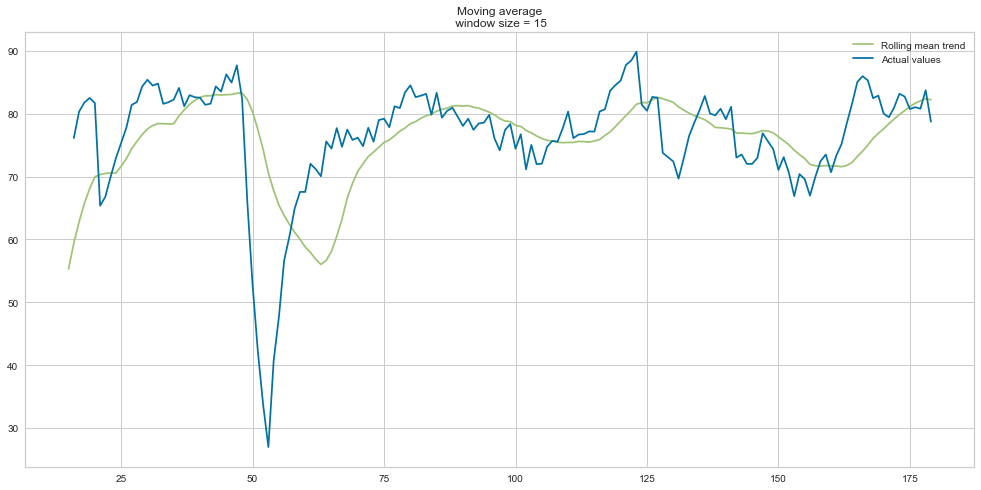

In [80]:
def plot_moving_average(series, window, length, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    arr = [i for i in range(1, length + 1)]
    plt.plot(arr, rolling_mean, 'g', label='Rolling mean trend')
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(arr,upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(arr, lower_bound, 'r--')          
    plt.plot(arr[window:], series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(person_dt.Function, 5, len(results))
#Smooth by the previous month (30 days)
plot_moving_average(person_dt.Function, 15, len(results))

გავაკეთოთ ისევ დიკი ფულერის ტესტი. ძირითად შემთხვევებში, რამდენად გასაკვირიც არ უნდა იყოს, ეს ტესტი 0-თან ახლო მნიშნელობებს აჩვენებს, თუმცა სტაციონალურს არაფრით არ გავს წესით, რადგან საშუალოს და ვარიაციის მნიშნელობები მარტივი შესამჩნევია, რომ ცვალებადია საკმაოდ. ამიტომ წესით ეს მოდელი არ გამოდგება იმისთვის, რომ კარგი შედეგები მივიღოთ, თუმცა მაინც ვცადოთ.

In [3]:
%matplotlib inline

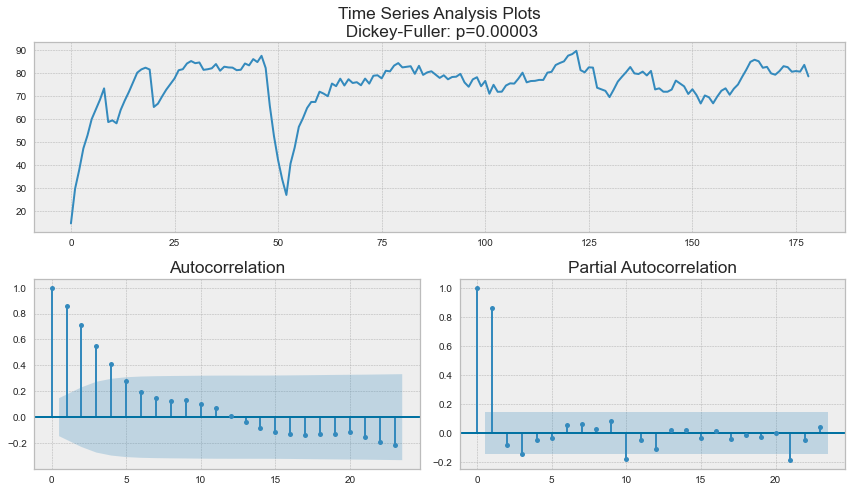

In [81]:
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
    return p_value 
        
p_value = tsplot(person_dt.Function, lags=None)

if p_value > 0.1:  
    # function()
    data_diff = person_dt.Function - person_dt.Function.shift(1)
    tsplot(data_diff[10:], lags=30)

აქ ხდება ოპტიმალური პარამეტრების არჩევა, ეს პროცესი უკვე გავიარეთ წინა ნაწილში.

In [82]:
from statsmodels.tsa.arima.model import ARIMA
ps = range(0, 5)
qs = range(0, 5)
d = 1
parameters = product(ps, qs)

In [83]:
def optimize_ARIMA(parameters_list, d):
    results = []
    best_aic = float('inf')
    for param in tqdm_notebook(parameters_list):
        model = ARIMA(person_dt.Function, order=(param[0], d, param[1])).fit()
        aic = model.aic
    
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    results = sorted(results, key=lambda x: x[1])
    
    return results[0][0]

In [84]:
p, q = optimize_ARIMA(list(parameters), d)

best_model = ARIMA(person_dt.Function, order=(p, d, q)).fit()

print(best_model.summary())

<ipython-input-83-a77b3cc36e53>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


C:\Users\Uturi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Uturi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Uturi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



                               SARIMAX Results                                
Dep. Variable:               Function   No. Observations:                  179
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -486.851
Date:                Sat, 20 Feb 2021   AIC                            991.703
Time:                        11:00:30   BIC                           1020.339
Sample:                             0   HQIC                          1003.315
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3054      0.116     -2.623      0.009      -0.534      -0.077
ar.L2          0.9673      0.132      7.331      0.000       0.709       1.226
ar.L3         -0.0041      0.095     -0.043      0.

C:\Users\Uturi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [85]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

s = 15

values = (best_model.predict(start=person_dt.Function.shape[0], end=person_dt.Function.shape[0] + s)).to_list()
print(mean_absolute_percentage_error(person_dt.Function[s+d:], best_model.fittedvalues[s+d:]))

3.40316975126439


In [86]:
comparison = pd.DataFrame({'actual': person_dt.Function[-s - 1:],
                          'predicted': values})

In [4]:
%matplotlib inline

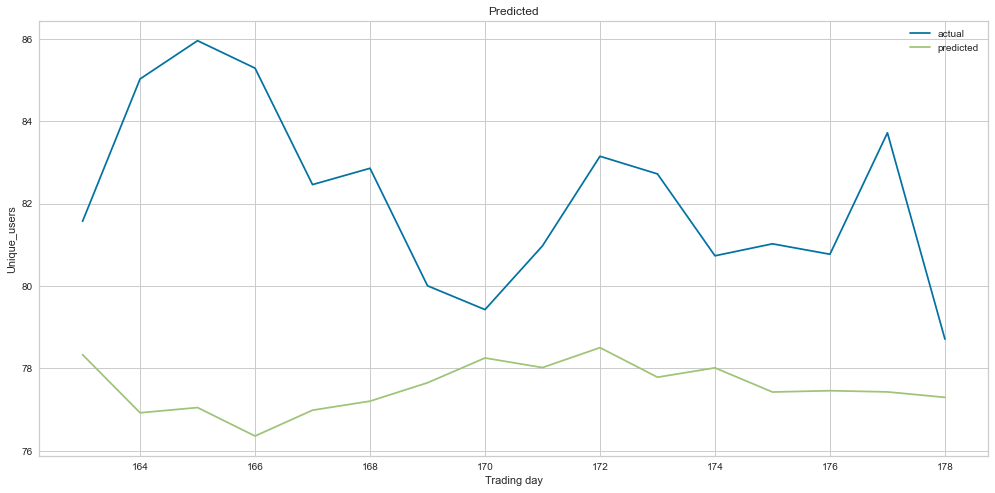

In [87]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.actual, label='actual')
plt.plot(comparison.predicted, label='predicted')
plt.title('Predicted')
plt.ylabel('Unique_users')
plt.xlabel('Trading day')
plt.legend()
plt.show()

როგორც ვივარაუდეთ, ფრედიქშენი არც ისე საამაყო გამოდგა. ამ ტიპის ფრედიქშენის გამოყენება ხდება კონკრეტულ იუზერებზე, ამიტომ თუ მაგალითად საჭიროა ყველა იუზერისთვის მსგავსი ინფორმაციის ამოღება, მოგვიწევს ამდენივე მოდელის შექმნა და გაშვება, რაც არც თუ ისე სახარბიელოა ეფექტურობის მხრივ. თუ გავითვალისწინებთ იმას, რომ ARIMA სტატისტიკური მოდელია და მუშაობის დროს და რესურსს ბევრს არ ხარჯავს, მისი გამოყენება მიზანშეწონილი უნდა იყოს, თუმცა, ვნახეთ, რომ საკმაოდ ცუდი შედეგი მოგვცა და დიდად გამოყენება არ შეიძლება. ამის გამომწვევი მიზეზი ის არის, რომ ეს stock-ები საკმაოდ რთული და არაპროგნოზირებადი ფორმისაა და შესაბამისად ბევრი მონაცემი სჭირდება, რომ მისაღებ შედეგზე გავიდეთ. წინა შემთხვევაშიც არ იყო ბოლომდე დამაკმაყოფილებელი შედეგი და ახლა მითუმეტეს.
როგორც ვთქვით, მოდელის მუშაობის დროის გაზრდა საკმაოდ შენელებას გამოიწვევს პროცესის, თუმცა ARIMA მოდელის შეცვლა აუცილებლად მოგვიწევს, რადგან მისი ეფექტურობა ძალიან ცოტაა. ვცადოთ რეკურენტური ნეირონული ქსელების გამოყენება, კონკრეტულად GRU მოდელის. როგორც ვიცით, შედეგის თვალსაზრისით LSTM მოდელი GRU ზე გაცილებით უკეთესია, მაგრამ აქ გვაქვს tradeoff მოდელის სისწრაფესა და ეფექტურობას შორის, ამიტომ GRU-ს არჩევა მოგვიწია.

In [88]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU

დავყოთ მონაცემები train-test ად, დავატრენინგოთ ნეირონული ქსელი ტრეინზე და ვნახოთ რა შედეგს მოგვცემს.

In [89]:
def train_test_split(data):
    X = []
    y = []
    for i in range(len(data) - 7):
        X.append(data[i:i+7])
        y.append(data[i+7])
    X = np.asarray(X)
    y = np.asarray(y)
    train_size = round(len(X) * 0.8)
    
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test

In [90]:
X_train, X_test, y_train, y_test = train_test_split(person_dt.Function.values)
X_train= X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [91]:
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.summary()
gru_model.fit(X_train, y_train, epochs=50, verbose=0)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 50)                8850      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 8,901
Trainable params: 8,901
Non-trainable params: 0
_________________________________________________________________


In [5]:
%matplotlib inline

2/2 [==============================] - 0s 2ms/step


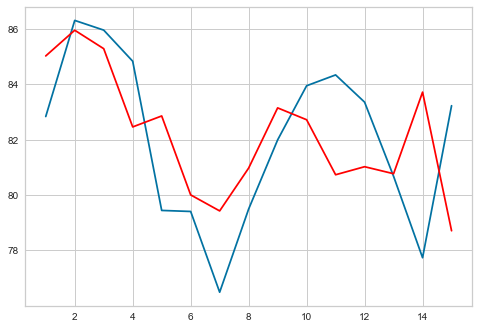

In [92]:
prediction = gru_model.predict(X_test, verbose=1)
plt.plot([i for i in range(1, s+1)], prediction[-s:])
plt.plot([i for i in range(1, s+1)], y_test[-s:], color='red')

შედეგი საკმაოდ მიმზიდველად გამოიყურება. ეფექტურობა საკმაოდ გაუმჯობესებულია, თუმცა GRU რახან ნეირონული ქსელია, მაინც საკმაო დროის რესურსს საჭიროებს. ამ კონკრეტულ შემთხვევაში დასჭირდა 2 მილიწამი. ეს კონრეტული მონაცემები რაც ავიღეთ, მაქსიმალურთან საკმაოდ ახლოსაა, და თუ გავითვალისწინებთ იმას, რომ იუზერების რაოდენობა დაახლოებით ათიათასია, მაშინ შეგვიძლია ვთქვათ, რომ ყველა იუზერსითვის ცალკე მოდელის შექმნა და გაშვებბის პროცესი დაახლოებით 20 წამს წაიღებს. ეს არც თუ ისე ცუდი შედეგია, თუმცა გაუმჯობესებაც შეიძლება (რა თქმა უნდა სიზუსტის ხარჯზე) gru ლეიერის პარამეტრების რაოდენობის შემცირებით.
-